# Лабораторная работа №Х
## "Работа со сверточными нейронными сетями на Keras"


Одесса - 2018

Связаться: TG @aionaction

Дисклеймер: некоторые рекомендации и утверждения могут быть некорректными. Пожалуйста, загуглите об этом, перед тем, как использовать это на практике.

Цель: научиться подготавливать данные для обучения сверточной нейронной сети; научиться строить и обучать модели с ипользованием библиотеки Keras, а также оценивать их качество.

Задание:
1. Ознакомиться с примером обучения нейронной сети на данных [NOT-MNIST](http://yaroslavvb.com/upload/notMNIST/)
2. Выполнить самостоятельно задание по обучению нейронности сети на данных MNIST
3. Сделать выводы о методике работы со сверточными нейронными сетями (а именно: подготовка данных, построение и обучение модели, оценка качества модели)

Теория: [1](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)
[2](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)

В качестве примера используется датасет NOT-MNIST, состоящий из разнообразных сгенерированных изображений 10 символов латиницы. Данный датасет предлагается в качестве альтернативы более стандартному и менее разнообразному датасету MNIST (коллекция изображений 10 рукописных цифр)

Для самостоятельного задания предлагается использовать датасет MNIST ввиду невысокой сложности необходимой модели для получения примелемого качества классификации

Подключим основные модули, которые будут использоваться. Если ошибка появилась тут, то нужно доустановить модули.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import Greys

import numpy as np

import keras
import sklearn

Using TensorFlow backend.


Загрузим изображения из файловой системы. Мы используем функцию `os.path.join` для конкатенации путей независимо от ОС, на которой запускается наш код (например, для Linux пути типа "path/to/file.txt", а в Windows - "path\to\file.txt")

In [2]:
def load_not_mnist(non_mnist_path):
    letters = os.listdir(non_mnist_path)
    
    X = list()
    Y = list()
    codes = dict()
    
    for index, letter in enumerate(letters):
        
        letter_dir = os.path.join(non_mnist_path, letter)
        letter_imgs = list()
        
        for img in os.listdir(letter_dir):
            
            img_path = os.path.join(non_mnist_path, os.path.join(letter, img))            
            letter_imgs.append(plt.imread(img_path, format='png'))
        
        # immadiantely transform to np.ndarray
        # for simple further transformations
        X.append(np.array(letter_imgs))
        Y.append(np.full(shape=(len(letter_imgs), 1), fill_value=index))
        
        # store letter label - numeric mark
        # for fancy output during prediction
        codes[letter] = index
        
        print("Loaded:", letter)
    
    # concatenate list of np.ndarray's 
    # to make a "stack" of images
    return np.concatenate(X), np.concatenate(Y), codes

In [3]:
non_mnist_path = 'not-mnist'

X, Y, codes = load_not_mnist(non_mnist_path)

Loaded: A
Loaded: B
Loaded: C
Loaded: D
Loaded: E
Loaded: F
Loaded: G
Loaded: H
Loaded: I
Loaded: J


Проверяем формат данных.

Видим, что получили массив двумерных изображений - следовательно трехмерный массив

In [4]:
X.shape

(18724, 28, 28)

Изображение отображается правильно

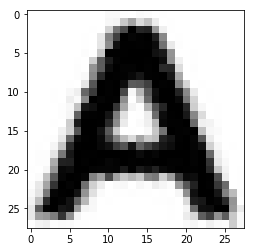

In [5]:
plt.imshow(X[0], cmap=Greys);

Длина массива меток соответствует длине массива объектов

In [51]:
Y.shape

(18724, 1)

Для первой буквы - "А", код "0"

In [52]:
Y[0]

array([0])

Обычно, при многоклассовой классификации с помощью нейронных сетей используется бинарная кодировка классов (унитарный код, [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f))

Таким образом каждому классу соответстует отдельный выходной нейрон.

В итоге по выходам сети мы получаем "уверенность" нейронной сети в том, что входной образ принадлежит определенному классу. Выходы так же можно интерпретировать, как вероятность принадлежности объекта классу.

Среди прочих утилит, Keras предоставляет функцию `to_categorical` (которая использована ниже), которая и совершает такое преобразование. 

In [7]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [53]:
Y_categ = to_categorical(Y).astype(np.float32)

Можно увидеть, что теперь мы получили 10 колонок вместо 1, как выше. 

Для первого класса, соответственно, видим код с 1 в колонке, соответствующей первому классу, и 0 - для остальных.

In [54]:
Y_categ.shape

(18724, 10)

In [56]:
Y_categ[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Далее, нам необходимо нормализовать признаки входных образов (из целочисленных 0..255 в 0..1 вещественных чисел). 

Это позволит нейронной сети быстрее сходиться (вспоминаем градиентный спуск: в формуле мы умножаем антиградиент на входные параметры; таким образом, приращения весов часто будут большими и мы рискуем постоянно проскакивать локальные оптимумы, пока веса не увеличатся на несколько порядков).

In [57]:
X = X.astype(np.float32) / 255.

Разобьем выборку на обучающую и тестовую (в соотношении 80/20; с соотношением можно экспериментировать, но опыт показывает, что такое соотношение дает неплохие результаты).

Это можно делать вручную, но для удобства используем функцию `sklearn.model_selection.train_test_split`

Обратите внимание, что перед разбиением вся выборка случайным образом перемешивается. Вообще, рекомендуется после формирования выборки первым делом ее перемешать, чтобы не возникло ситуации, когда большая часть одного из классов попала в тестовую выборку, а в обучающую - нет, потому что она была в конце массива и этот кусок мы вырезали в тестовую выборку.

In [10]:
test_rate = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y_categ, test_size=test_rate, random_state=1, shuffle=True)

После разбиения снова проверим корректность данных, чтобы избежать сюрпризов при обучении.

In [11]:
x_train.shape

(14979, 28, 28)

In [12]:
x_test.shape

(3745, 28, 28)

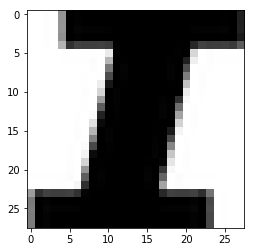

In [13]:
plt.imshow(x_train[0], cmap=Greys);

Приступим к формированию модели (нейронной сети).

Имортируем из Keras нужные инструменты:
 - Sequential - обозначет последовательную (нереккурентную нейронную сеть)
 - Dense - полносвязный слой
 - Conv2D - двумерный сверточный слой
 - MaxPooling2D - макс-пуллинг слой, который выбирает максимальное значнение из окна
 - Dropout - специальный слой, который во время каждой итерации обучения "блокирует" определенные нейроны из последующего слоя таким образом, что они не учавствуют в обучении; так, нейроны в слое обучаются равномернее и мы снижаем риск переобучения сети
 - Flatten - преобразует входы любой размерности в одномерный вектор

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Можно увидеть, что модель с помощью Keras строится быстро и просто.

Для первого слоя модели всегда указываем `input_shape` (если не используем слой Input)

В общем виде, для каждого слоя мы указываем
- количество нейронов 
- размер ядра свертки (для сверточных слоев)
- функцию активации

Возможные вопросы
- Почему для скрытых слоев используем функцию активации `ReLU`? 
     
     Эта функция активации позволяет сигналу распротраняться по слоям далее, не затухая, так как она не ограничивает его сверху (гуглим для деталей)


- Почему в последнем слое используем функцию активации `Softmax`?
    
    Эта функция активации "мягко" масштабирует любой сигнал к непрерывной области 0..1, а мы как раз хотим получать такой ответ ("уверенность" сети в принадлежности объекту данному классу, где 0 - точно нет, а 1 - точно да)


- Почему именно такое количество слоев/нейронов в слоях?

    Потому что так надо. Для выбора этих параметров есть ограниченно работающие эвристики, но общее правило - это опираться на интуицию и экспериментировать. Например, для сложных данных (в готовых данных много признаков, специфическая предметная область, априорные знания о распределении объектов и т.п.), часто необходимо применить более сложную модель, но в меру, чтобы она не переобучилась и максимально обобщала обучающую выборку; как правило, мы стремимся создать наиболее простую модель с наилучшими характеристиками. Чтобы строить хорошие модели, нужно много экспериментировать.
    

- Как выбрать функцию потерь?

    Зависит от типа данных и постановки задачи (функции, которую оптимизируем). Например, [так](https://qr.ae/TUtudU).

    
- Какой оптимизатор выбрать?

    В зависимости от задачи и от доступных оптимизаторов. Читаем документацию, выбираем, что больше понравилось. У каждого оптимизатора есть определенные преимущества и недостатки в разных задачах

In [28]:
def create_cnn_not_mnist():
    input_shape = (28, 28, 1)
    num_classes = 10
    
    model = Sequential()
    
    model.add(Conv2D(
        filters=32, 
        kernel_size=(3,3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
    )
    
    return model

Посмотрим сводку по модели.

In [29]:
model_not_mnist = create_cnn_not_mnist()
model_not_mnist.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Модели Keras требуют определенной формы данных для обучения, а именно массив полных объектов. Например, для изображений: (кол-во образов, ширина, высота, количество каналов). Так, как у нас однотонное изображение размером 28 на 28, нам необходима форма (кол-во образов, 28, 28, 1)

Метод `ndarray.reshape` позволяет нам сделать нужную трансофрмацию. Размерность -1 при остальных определенных говорит методу высчитать эту размерность на основании остальных

Внимание. Если определить некорректные размерности, то данные "перемешаются" и получим бесполезные данные

In [30]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [21]:
x_train.shape

(14979, 28, 28, 1)

In [22]:
x_test.shape

(3745, 28, 28, 1)

Обучим модель.
Передаем обучающую выборку и тестовую в качестве валидационной.

`batch_size` выбирается на свое усмотрение; общие правила:
- малое значение замедляет обучение, веса становятся менее чувствительными, а функция потерь и точность медленно меняются; при этом затрачивается меньше памяти; обычно малые значения применяются для "полировки" модели, когда речь идет о сотых и тысячных долях точности
- большое значение ускоряет обучение, веса, функция потерь и точность в большей мере меняются; полезно использовать большие значения в начале обучения, или когда точность не меняется, тогда таким образом можно "выскочить" из локального оптимума, затрачивается больше памяти

`epochs` выбирается по необходимости (помним, что эпоха обучения - это один проход по всей обучающей выборке).


Метод `model.fit` при повторном запуске продолжает обучать модель с того места, где оно остановилось в прошлый раз (даже если вы прервали выполнение ячейки). Данный метод возвращает объект результатов обучения, в котором имеется история метрик по эпохам.

Часто необходимо делать серии обучения с разным количеством эпох и размером батча. Например 10 эпох с размером 128, 20 эпох с размером 64 и т.д.

Внимание. Если после запуска следующей ячейки машина зависла, или кернел jupyter перезапустился, это значит, что модель слишком сложная для обучения на Вашей машине. Тогда вернитесь к ячейке с определением модели и уменьшите количество нейронов в каждом слое в два раза и увеличивайте до тех пор, пока используемая мощность не станем максимально допустимой. Естветсвенно, максимальная точность в таком случае может быть ниже (а может и не быть) или для ее достижения необходимо большее количество эпох.

In [31]:
history = model_not_mnist.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test)
)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 27s 2ms/step - loss: 2.3029 - acc: 0.1007 - val_loss: 2.3028 - val_acc: 0.1009
Epoch 2/10
14979/14979 [==============================] - 26s 2ms/step - loss: 2.2723 - acc: 0.1475 - val_loss: 1.7296 - val_acc: 0.5610
Epoch 3/10
14979/14979 [==============================] - 27s 2ms/step - loss: 0.9481 - acc: 0.7145 - val_loss: 0.5416 - val_acc: 0.8446
Epoch 4/10
14979/14979 [==============================] - 27s 2ms/step - loss: 0.6185 - acc: 0.8246 - val_loss: 0.4541 - val_acc: 0.8713
Epoch 5/10
14979/14979 [==============================] - 27s 2ms/step - loss: 0.5736 - acc: 0.8351 - val_loss: 0.4493 - val_acc: 0.8638
Epoch 6/10
14979/14979 [==============================] - 27s 2ms/step - loss: 0.5297 - acc: 0.8469 - val_loss: 0.4281 - val_acc: 0.8769
Epoch 7/10
14979/14979 [==============================] - 28s 2ms/step - loss: 0.5004 - acc: 0.8508 - val_loss: 0.4121 - val_acc:

Модель обучилась. Построим графики точности и значений функции потерь по эпохам.

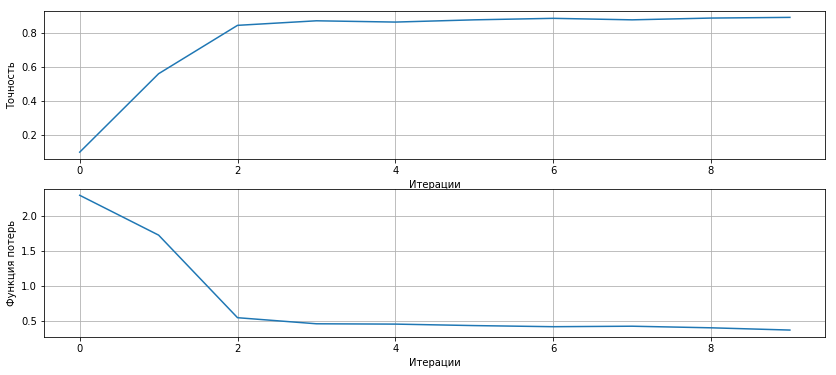

In [45]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)

plt.plot(history.history['val_acc'])

plt.xlabel('Итерации')
plt.ylabel('Точность')
plt.grid()

plt.subplot(2, 1, 2)

plt.plot(history.history['val_loss'])

plt.xlabel('Итерации')
plt.ylabel('Функция потерь')
plt.grid()

Оценим качество модели

In [47]:
score = model_not_mnist.evaluate(x_test, y_test)

3745/3745 [==============================] - 1s 358us/step


In [48]:
print("Функция потерь на тестовой выборке: ", score[0])
print("Точность на тестовой выборке: ", score[1])

Функция потерь на тестовой выборке:  0.3637173531688899
Точность на тестовой выборке:  0.8913217623497998


## Самостоятельная работа

In [58]:
from keras.datasets import mnist

Загрузка данных

In [59]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Нормализация входных объектов

Кодирование меток классов

Не забываем проверить формат данных
- `shape` выборки
- содержание объектов
- количество классов
- ...

Построение нейронной сети

In [60]:
def create_model_mnist():
    model = Sequential()
    
    # insert convolutional layers
    # insert dense layers
    # compile model
    
    return model

In [61]:
model_mnist = create_cnn_not_mnist()

Краткая сводка по модели

Обучение модели.
Входные данные соответствуют необходимому для Keras формату?

In [ ]:
history = model_mnist.fit(
    # ...
)

Оценка качества модели на тестовой выборке

In [ ]:
score_mnist = model_mnist.evaluate(x_test, y_test)

In [ ]:
print("Функция потерь на тестовой выборке: ", score_mnist[0])
print("Точность на тестовой выборке: ", score_mnist[1])